## Evolutional Strategies (ES)

* [Initial Implementation](#initial)
* [ES with Gradient Estimation (Regression Based with Regularization)](#gradient)
* [ES with Control Variate](#control)
* [Compare with Gradient Descent](#descent)

This notebook is to show our understanding of Evolutional Strategies (ES). ES method is a blackbox optimization method. Suppose we don't know the blackbox function $F$, and we want to find an optimal parameter $\theta$ that minimizes this $F$. We are unable to explicitly compute its gradient because it is a blackbox function. However, at current $\theta$, we can generate a set of gaussian noises as the direction/perturbation on our current parameter, and move our current parameter to the noise which minimizes $F$, or which gives the best proxy for the gradient on the direction of those noises. By doing so iteratively, we can find our optimal parameter $\theta$. This is the general idea of ES method.

For example, define a blackbox function as:

\begin{equation}
F(\theta = \{\theta_1, \theta_2, \theta_3\}) = e^{\theta_1+\theta_2 - 5\theta_3 +0.1} + e^{\theta_1-\theta_2+\theta_3-0.1}+e^{-0.1 \theta_1-0.1} 
\end{equation}

Let's proceed with an ES method to find an optimal $\theta^*$ that minimize this blackbox function $F$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [ ]:
def evalfun(x1,x2,x3):
    e1 = np.exp(x1 + x2 - 5*x3 + 0.1)
    e2 = np.exp(x1 - x2 + x3 - 0.1)
    e3 = np.exp(-0.1*x1 - 0.1)
    return (e1 + e2 + e3)

___

### First Method <a name="initial"></a>

- Initialize a random $\theta_0$; 
- Around $\theta_0$, generate $N$ number of gaussian noises $g_{i\in \{1,2,3, ..., N\}}$ as the direction we want to move our $\theta_0$;
- Update $\theta' = \theta_0 + \epsilon g_i$;
- Put $\theta'$ into our blackbox function $F$, compare those $N$ results and choose the one with the best value;
- Repeat until an optimal value $\theta^*$ is found.

In [ ]:
### Initialization
numParams = 3
theta_0   = np.random.randn(numParams)         # Initialize a random theta_0
current_F = evalfun(theta_0[0], theta_0[1], theta_0[2])
numIter   = 500
numNoises = 100
mu, sigma = 0, 0.5 
epsilon   = 0.1
vectorFun = np.vectorize(evalfun)
threshold = 1e-20

In [ ]:
F_vec = []       # List to store current function value
for step in range(numIter):
    Z = np.random.normal(mu, sigma, (numNoises, numParams))    # Create gaussian noises
    new_theta  = theta_0 + Z*epsilon                           # Update theta
    last_opt_F = current_F
    for noise in range(Z.shape[0]):
        x1, x2, x3 = new_theta[noise][0], new_theta[noise][1], new_theta[noise][2]
        F = evalfun(x1, x2, x3)
        if F < current_F:
            current_F = F
            theta_0 = new_theta[noise]             # Choose the best direction g
    if abs(last_opt_F - current_F) < threshold:    # Stop if we didn't make any significant improvement
        break
    F_vec.append(current_F)
    
print(f'Optimal F = {current_F:.5f}')

Optimal F = 0.06941


Text(0, 0.5, 'F')

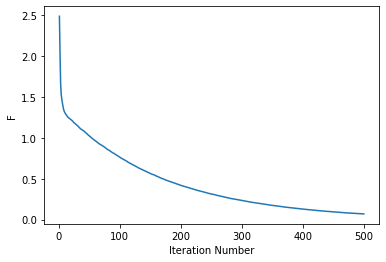

In [ ]:
plt.plot(range(1,(len(F_vec)+1)), F_vec)
plt.xlabel("Iteration Number")
plt.ylabel("F")

___

### ES Method with Different Regression Based Gradient Estimating and Gaussian Smoothing <a name="gradient"></a>

In [ ]:
### Initialization
numParams = 3
theta_0   = np.random.randn(numParams)
numIter   = 500
numNoises = 100
mu, sigma = 0, 0.001 
epsilon   = 0.9
alpha = 0.01

Build up on what we discussed above, here we add more color into our vanilla ES method. Use finite difference, we can set the gradient in the direction of each gaussian noise $g_i$ as $y_i$:

\begin{equation}
y_i = \frac{F(\theta + \epsilon g_i) - F(\theta)}{\epsilon}
\end{equation}

To find an estimated gradient on the direction of each $g_i$, we can use regression based method with regularization to solve an objective function as below:

\begin{equation}
\hat{\nabla} = argmin_{v\in R^3} \frac{1}{2N} ||y-Zv||_p^p + \alpha ||v||_q^q
\end{equation}

* If we use LASSO regularizer, we can set q = 1 to compute $l$-1 norm. (not always work b/c it forces some elements in v to zero after certain iterations, need to tune learning rate and gaussian parameters)
* If we use Ridge, we can set q = 2 to compute $l$-2 norm.
* If we use LP-decoding, we can set $\alpha$ = 0

Once we have estimated gradient $\hat{\nabla}F(\theta)$, we can update $\theta$ with 

$$ \theta' = \theta - \epsilon \hat{\nabla}$$

By doing so iteratively, we can find our optimal $\theta^*$

In [ ]:
def ES_with_regularization(method, numIter, numParams, numNoises, mu, sigma, epsilon, alpha=0.1):
    F_vec   = []
    theta_0 = np.random.randn(numParams)
    
    if method == 'LASSO':
        model = linear_model.Lasso(alpha)
    elif method == 'Ridge':
        model = linear_model.Ridge(alpha)
    else:
        model = linear_model.LinearRegression()
        
    for step in range(numIter):
        current_F = evalfun(theta_0[0], theta_0[1], theta_0[2])
        F_vec.append(current_F)
        Z = np.random.normal(mu, sigma, (numNoises, numParams))     # Change Z for Control Variate
        new_theta  = theta_0 + Z*epsilon
        y = np.zeros(numNoises)                                     # Gradient on the direction of noise

        for noise in range(Z.shape[0]):
            x1, x2, x3 = new_theta[noise][0], new_theta[noise][1], new_theta[noise][2]
            F = evalfun(x1, x2, x3)
            y[noise] = (F-current_F)/epsilon

        model.fit(Z, y)           # Solve the objective function above
        v = model.coef_           # Estimated gradient
        theta_0 = theta_0 - epsilon*v

    print(f'Optimal F = {current_F:.5f}')
    plt.plot(range(1,(len(F_vec)+1)), F_vec)
    

Optimal F = 1.13900


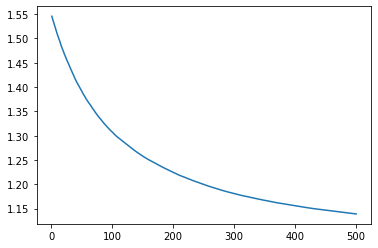

In [ ]:
ES_with_regularization("Ridge", numIter, numParams, numNoises, mu, sigma, epsilon, alpha=0.01)

___

### ES Method with Control Variate <a name="control"></a>

* Antithetic Variate

There are several ways for the Antithetic Variate method to reduce the variance here. One way is to create a $Z$ matrix with the second half columns to be the additive inverse to the first half. However, this method requires the number of columns to be an even number, which doesn't work out here as we have 3 parameters. Another way is to create first $N/2$ noises, and the remaining just put $-1$ in front of these $N/2$ noises. There are also other ways, for instance,

$$ \hat{\nabla}= \frac{1}{2N\epsilon} \sum_{i=1}^{N} (F(\theta+\epsilon g_i)g_i - F(\theta - \epsilon g_i)g_i) $$

For an illustration, we used method 2 as below:

In [ ]:
### Initialization
numParams = 3
theta_0   = np.random.randn(numParams)         # Initialize a random theta_0
current_F = evalfun(theta_0[0], theta_0[1], theta_0[2])
numIter   = 500
numNoises = 100
mu, sigma = 0, 0.5 
epsilon   = 0.1
vectorFun = np.vectorize(evalfun)
threshold = 1e-20

In [ ]:
F_vec = []
for step in range(numIter):
    Z_1 = np.random.normal(mu, sigma, (numNoises//2, numParams))
    Z_2 = -Z_1
    Z = np.concatenate((Z_1, Z_2),axis=0)
    new_theta  = theta_0 + Z*epsilon
    last_opt_F = current_F
    for noise in range(Z.shape[0]):
        x1, x2, x3 = new_theta[noise][0], new_theta[noise][1], new_theta[noise][2]
        F = evalfun(x1, x2, x3)
        if F < current_F:
            current_F = F
            theta_0 = new_theta[noise]           # Choose the best direction g
    if abs(last_opt_F - current_F) < threshold:
        break
    F_vec.append(current_F)
    
print(f'Optimal F = {current_F:.5f}')

Optimal F = 0.00339


Compared with the initial implementation, it is clear that the result after control variate looks better than the vanilla version.

Text(0, 0.5, 'F')

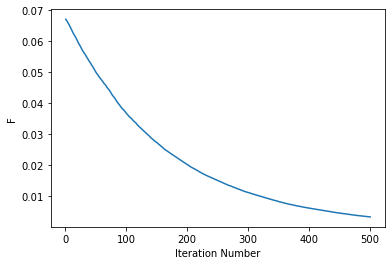

In [ ]:
plt.plot(range(1,(len(F_vec)+1)), F_vec)
plt.xlabel("Iteration Number")
plt.ylabel("F")

* Hadamard Matrix:

One problem with our vanilla ES method is that if we generate $N$ noises completely random, we are having chance to have dependencies among noises in sub-dimensions. To make sure that we span the whole space, we need to make our noise matrix $Z$ to have orthoginal rows. This is where Hadamard Matrix comes into place.

For this function, Hadamard matrix is not a perfect example because we have odd number of parameters to be count for the gradient. However, we need to be aware of that even though the dimension is not a perfect fit, we can still apply Hadamard matrix here as well by adding 0 to the 4th parameter. 

In [ ]:
def hadamard_mat(size, mu, sigma):
    '''
    Input: size must be an even number
    '''
    result    = np.zeros((size, size))
    half_size = size//2
    mat = np.random.normal(mu, sigma, (half_size, half_size))
    result[:half_size, :half_size] = mat
    result[:half_size, half_size:] = mat
    result[half_size:, :half_size] = mat
    result[half_size:, half_size:] = -mat
    
    return result

___

### Compare the result with gradient descent method <a name="descent"></a>

In [ ]:
def evalgrad(x1,x2,x3):
    e1 = np.exp(x1 + x2 - 5*x3 + 0.1)
    e2 = np.exp(x1 - x2 + x3 - 0.1)
    e3 = np.exp(-0.1*x1 - 0.1)
    g1 = e1 + e2 - 0.1*e3
    g2 = e1 - e2
    g3 = -5*e1 + e2
    return g1, g2, g3

In [ ]:
def backtrack(x1,x2,x3, fval, g1,g2,g3, delta1,delta2,delta3, loud):
    alpha = 0.5
    beta = 0.75
    gradtimesdelta = g1*delta1 + g2*delta2 + g3*delta3
    t = 1
    goon = True
    while goon:
        fnew = evalfun(x1 + t*delta1, x2 + t*delta2, x3 + t*delta3)
        target = alpha*t*gradtimesdelta
        if fnew - fval <= target:
            goon = False
            if loud:
                print('done!')
        else:
            t = beta*t
        if t < 0.01:
            goon = False
    return t

* Gradient Descent

In [ ]:
x1 = .6
x2 = .5
x3 = .4
N = 250
x1sol = np.zeros(N)
x2sol = np.zeros(N)
x3sol = np.zeros(N)
fvalsol = np.zeros(N)
for iteration in range(N):
    x1sol[iteration] = x1
    x2sol[iteration] = x2
    x3sol[iteration] = x3
    fval = evalfun(x1,x2,x3)
    fvalsol[iteration] = fval
    g1, g2, g3 = evalgrad(x1,x2,x3)

    delta1 = -g1
    delta2 = -g2
    delta3 = -g3

    t = backtrack(x1,x2,x3,fval,g1,g2,g3,delta1,delta2,delta3,False)
    newx1 = x1 + t*delta1
    newx2 = x2 + t*delta2
    newx3 = x3 + t*delta3
    newfval = evalfun(newx1,newx2,newx3)
    x1 = newx1
    x2 = newx2
    x3 = newx3

print(f'Function value = {newfval:.4f}')

Function value = 0.6730
